# Vision Transformers

## Set Up

In [1]:
%pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Layer, Add, Flatten, Dropout, Reshape
from tensorflow.keras.layers import Dense, Embedding, LayerNormalization, MultiHeadAttention
MSA = MultiHeadAttention
from tensorflow.keras import Model, Sequential
from keras import backend as K
import tensorflow_addons as tfa
import numpy as np
from matplotlib import pyplot

import os
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab/CS\ 747/proj_src
print("drive ready")

Mounted at /gdrive
/gdrive/My Drive/Colab/CS 747/proj_src
drive ready


In [4]:
from MakePatchesLayer import MakePatchesLayer, test_patches
from ProjectPatchesLayer import ProjectPatchesLayer, test_projection
from EmbedPatchesLayer import EmbedPatchesLayer, test_embedding
from MLP import MLP, test_mlp
from ViT_ImageSeg import build_ViT_ImageSeg, test_vit

# test_patches()
# test_projection()
# test_embedding()
# test_mlp()
# test_vit()
# print("\nAll source code tested")

# Segmentation Dataset
CityScapes dataset \
download here: https://www.kaggle.com/datasets/zhangyunsheng/cityscapes-data

In [5]:
train_data_path = "cityscapes/train"
test_data_path = "cityscapes/test"

image_edge = 256

def gather_images(path):
  X = []
  Y = []
  for file in tqdm(os.listdir(path), desc="reading images"):
    image = Image.open(path+"/"+file).resize(size=(image_edge*2, image_edge))
    image = np.asarray(image)
    # shape is (y,x,color)
    assert image.shape == (image_edge,image_edge*2,3), f"improperly sized image -- {image.shape}"
    width=image.shape[1]
    x = image[:,:width//2] # color image is left half
    y = image[:,width//2:] # segmented is right half
    X+=[tf.convert_to_tensor(x, dtype=tf.uint8)]
    Y+=[tf.convert_to_tensor(y/255.0, dtype=tf.float16)]

  X,Y = tf.stack(X), tf.stack(Y)
  return X,Y

trainX, trainY = gather_images(train_data_path)
testX, testY = gather_images(test_data_path)

reading images:   0%|          | 0/2975 [00:00<?, ?it/s]

reading images:   0%|          | 0/500 [00:00<?, ?it/s]

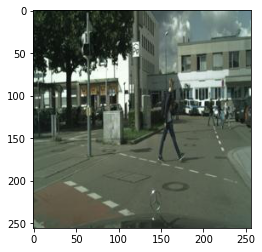

In [6]:
demo_image = Image.fromarray(trainX[123].numpy())
pyplot.imshow(demo_image)

# input images are full color

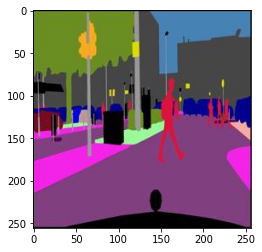

In [7]:
demo_image = Image.fromarray((trainY[123].numpy()*255).astype(np.uint8))
pyplot.imshow(demo_image)

# output images colored per class

# ViT for Image Segmentation

In [ ]:
vit_model = build_ViT_ImageSeg(
      # patching
      image_edge=image_edge, # edge of input/output image
      spatial_emb=8,
      P=16, # pixel edge per patch
      D=128, # patch projection latent size
      
      # transformer 
      n_transformer_blocks=4,
      n_attention_heads=8,
      MLP_units=[512,1024], # encoder MLP
      final_encoder_MLP_units=[1024,2048],
      features_per_patch=32,

      # decoder
      D2=128, # decoder patch projection latent size
      decoder_MLP_units=[512,512,512,512],
  )
loss_fn = keras.losses.MeanAbsoluteError()
optimizer = tfa.optimizers.AdamW(learning_rate=0.005, weight_decay=0.0001)
vit_model.compile(loss=loss_fn, optimizer=optimizer, metrics=['acc'])
print("model compiled")

In [10]:
history = vit_model.fit(x=trainX, y=trainY, batch_size=16, epochs=100, validation_split=0.2, shuffle=True)

Epoch 1/100
149/149 [==============================] - 27s 121ms/step - loss: 0.1599 - acc: 0.3537 - val_loss: 0.1211 - val_acc: 0.4638
Epoch 2/100
149/149 [==============================] - 17s 111ms/step - loss: 0.1133 - acc: 0.4777 - val_loss: 0.1115 - val_acc: 0.5128
Epoch 3/100
149/149 [==============================] - 16s 111ms/step - loss: 0.1102 - acc: 0.5131 - val_loss: 0.1121 - val_acc: 0.5922
Epoch 4/100
149/149 [==============================] - 16s 110ms/step - loss: 0.1096 - acc: 0.5334 - val_loss: 0.1107 - val_acc: 0.5829
Epoch 5/100
149/149 [==============================] - 16s 111ms/step - loss: 0.1092 - acc: 0.5509 - val_loss: 0.1109 - val_acc: 0.5719
Epoch 6/100
149/149 [==============================] - 16s 110ms/step - loss: 0.1090 - acc: 0.5542 - val_loss: 0.1118 - val_acc: 0.5906
Epoch 7/100
149/149 [==============================] - 16s 111ms/step - loss: 0.1088 - acc: 0.5592 - val_loss: 0.1104 - val_acc: 0.5758
Epoch 8/100
149/149 [===========================

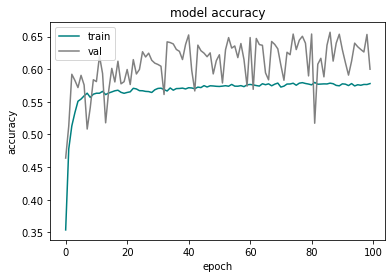

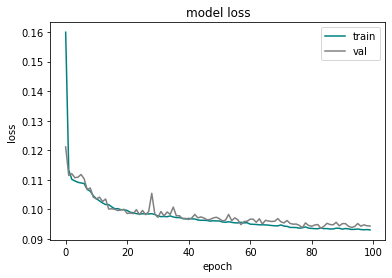

In [11]:
def make_charts(train_history):
  plt.plot(train_history.history['acc'], color="teal")
  plt.plot(train_history.history['val_acc'], color="gray")
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(train_history.history['loss'], color="teal")
  plt.plot(train_history.history['val_loss'], color="gray")
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()
make_charts(history)

In [17]:
vit_model.evaluate(x=testX, y=testY)

16/16 [==============================] - 1s 71ms/step - loss: 0.0937 - acc: 0.6367


[0.09373370558023453, 0.6367260813713074]

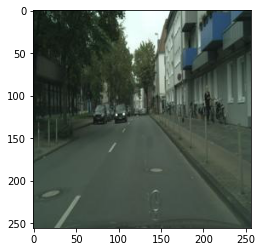

In [37]:
test_indx = 50
demo_image = Image.fromarray(testX[test_indx].numpy())
pyplot.imshow(demo_image)

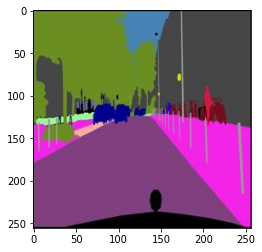

In [38]:
demo_image = Image.fromarray((testY[test_indx].numpy()*255).astype(np.uint8))
pyplot.imshow(demo_image)

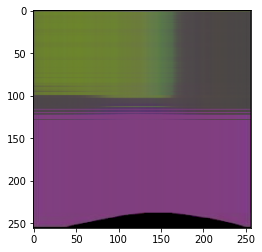

In [39]:
pred = vit_model.predict(testX[test_indx:test_indx+1])[0]
demo_image = Image.fromarray((pred*255).astype(np.uint8))
pyplot.imshow(demo_image)

In [40]:
vit_model.save("vit_model")

INFO:tensorflow:Assets written to: vit_model/assets


INFO:tensorflow:Assets written to: vit_model/assets
